# Machine Learning para Previsão de Taxas de Qualis de Professores

## Bibliotecas Importadas

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import warnings as wrn
import matplotlib.pyplot as plt

## Importação de Bibliotecas de Machine Learning

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Importação de Bibliotecas de Otimização de Hiperparâmetros

In [3]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

## Leitura e Seleção de Colunas do Arquivo CSV

In [4]:
# selecionar atributos dos professores que sao de interesse

tp_cols = ["siape", "sexo", "formacao", "tipo_jornada_trabalho",
           "vinculo", "id_unidade_lotacao", "lotacao", "admissao", "categoria",
           "classe_funcional"]

tp_df = pd.read_csv("./perfis/docentes.csv", sep=";")
tp_df = tp_df[tp_cols]

tp_df

,siape,sexo,formacao,tipo_jornada_trabalho,vinculo,id_unidade_lotacao,lotacao,admissao,categoria,classe_funcional
0,1543339,F,MESTRADO,Dedicação exclusiva,Ativo Permanente,1452,NÚCLEO DE EDUCAÇÃO DA INFÂNCIA,2006/07/24 00:00:00.000000000,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DIV ...
1,1554468,M,DOUTORADO,Dedicação exclusiva,Ativo Permanente,351,ESCOLA AGRÍCOLA DE JUNDIAÍ,2008/09/12 00:00:00.000000000,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DV ...
2,1177821,M,MESTRADO,Dedicação exclusiva,Ativo Permanente,284,ESCOLA DE MÚSICA,1998/04/28 00:00:00.000000000,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DIV ...
3,2360824,M,MESTRADO,Dedicação exclusiva,Ativo Permanente,351,ESCOLA AGRÍCOLA DE JUNDIAÍ,2017/01/25 00:00:00.000000000,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DIII ...
4,2364334,F,DOUTORADO,Dedicação exclusiva,Ativo Permanente,351,ESCOLA AGRÍCOLA DE JUNDIAÍ,2009/10/13 00:00:00.000000000,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DIV ...
...,...,...,...,...,...,...,...,...,...,...
2765,4246363,M,DOUTORADO,Dedicação exclusiva,Professor Visitante,1824,INSTITUTO DE POLÍTICAS PÚBLICAS,2023/05/23 00:00:00.000000000,PROFESSOR MAGISTERIO SUPERIOR - VISITANTE,Adjunto ...
2766,3304576,M,DOUTORADO,Dedicação exclusiva,Professor Visitante,4885,ESCOLA DE CIÊNCIAS E TECNOLOGIA,2022/08/12 00:00:00.000000000,PROFESSOR MAGISTERIO SUPERIOR - VISITANTE,Titular ...
2767,1056188,M,DOUTORADO,Dedicação exclusiva,Professor Visitante,179,DEPARTAMENTO DE BIOLOGIA CELULAR E GENÉTICA,2022/10/03 00:00:00.000000000,PROFESSOR MAGISTERIO SUPERIOR - VISITANTE,A ...
2768,3330361,F,DOUTORADO,Dedicação exclusiva,Professor Visitante,6069,INSTITUTO METROPOLE DIGITAL,2023/02/15 00:00:00.000000000,PROFESSOR MAGISTERIO SUPERIOR - VISITANTE,A ...


## Tipos de Dados das Colunas

In [5]:
tp_df.dtypes

siape                     int64
sexo                     object
formacao                 object
tipo_jornada_trabalho    object
vinculo                  object
id_unidade_lotacao        int64
lotacao                  object
admissao                 object
categoria                object
classe_funcional         object
dtype: object

## Resumo Estatístico do DataFrame

In [6]:
tp_df.describe()

,siape,id_unidade_lotacao
count,2.770000e+03,2770.000000
mean,2.114588e+06,2821.146209
std,1.142222e+06,5617.495694
min,1.274600e+04,2.000000
25%,1.297595e+06,142.000000
50%,1.810985e+06,202.000000
75%,2.722937e+06,4890.000000
max,9.350807e+06,31231.000000


## Preparação dos Dados de Qualis das Revistas

In [7]:
# selecionar atributos que desejamos prever. o siape é incluso para unir as tabelas.

qualis = ["siape", "revista_a1", "revista_a2", "revista_b1",
          "revista_b2", "revista_b3", "revista_b4", "revista_b5", "revista_c"]

ti_df_list = []
for year in range(2010, 2021):
    ti_df_y = pd.read_csv(
        "./indicadores/indicadores-pesquisa-" + str(year) + ".csv", sep=";")
    ti_df_y = ti_df_y[qualis]
    ti_df_list.append(ti_df_y)

ti_df = pd.concat(ti_df_list)
ti_df = ti_df.groupby("siape", as_index=False).sum()
ti_df.describe()

,siape,revista_a1,revista_a2,revista_b1,revista_b2,revista_b3,revista_b4,revista_b5,revista_c
count,2.756000e+03,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000
mean,2.112227e+06,2.634978,1.933599,1.750000,1.269231,0.818215,0.568578,0.054790,0.889332
std,1.137681e+06,6.073799,3.917333,5.375914,2.891393,2.413658,1.778480,0.330389,3.855806
min,1.274600e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.296285e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.808676e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.721404e+06,3.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,9.350807e+06,71.000000,51.000000,99.000000,46.000000,41.000000,32.000000,8.000000,124.000000


## Fusão de Dados e Remoção da Coluna "siape"

In [8]:
# unir ambas as tabelas e manter apenas as entradas que possuem siapes em comum

df = tp_df.merge(ti_df, on="siape", how="inner")
del df["siape"]

df

,sexo,formacao,tipo_jornada_trabalho,vinculo,id_unidade_lotacao,lotacao,admissao,categoria,classe_funcional,revista_a1,revista_a2,revista_b1,revista_b2,revista_b3,revista_b4,revista_b5,revista_c
0,F,MESTRADO,Dedicação exclusiva,Ativo Permanente,1452,NÚCLEO DE EDUCAÇÃO DA INFÂNCIA,2006/07/24 00:00:00.000000000,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DIV ...,0,0,0,0,0,0,0,0
1,M,DOUTORADO,Dedicação exclusiva,Ativo Permanente,351,ESCOLA AGRÍCOLA DE JUNDIAÍ,2008/09/12 00:00:00.000000000,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DV ...,1,1,5,0,0,4,0,0
2,M,MESTRADO,Dedicação exclusiva,Ativo Permanente,284,ESCOLA DE MÚSICA,1998/04/28 00:00:00.000000000,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DIV ...,0,0,0,0,0,0,0,0
3,M,MESTRADO,Dedicação exclusiva,Ativo Permanente,351,ESCOLA AGRÍCOLA DE JUNDIAÍ,2017/01/25 00:00:00.000000000,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DIII ...,0,0,0,0,0,0,0,0
4,F,DOUTORADO,Dedicação exclusiva,Ativo Permanente,351,ESCOLA AGRÍCOLA DE JUNDIAÍ,2009/10/13 00:00:00.000000000,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DIV ...,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2748,M,DOUTORADO,Dedicação exclusiva,Professor Visitante,1824,INSTITUTO DE POLÍTICAS PÚBLICAS,2023/05/23 00:00:00.000000000,PROFESSOR MAGISTERIO SUPERIOR - VISITANTE,Adjunto ...,0,0,0,1,0,0,0,1
2749,M,DOUTORADO,Dedicação exclusiva,Professor Visitante,4885,ESCOLA DE CIÊNCIAS E TECNOLOGIA,2022/08/12 00:00:00.000000000,PROFESSOR MAGISTERIO SUPERIOR - VISITANTE,Titular ...,8,4,7,0,2,0,0,0
2750,M,DOUTORADO,Dedicação exclusiva,Professor Visitante,179,DEPARTAMENTO DE BIOLOGIA CELULAR E GENÉTICA,2022/10/03 00:00:00.000000000,PROFESSOR MAGISTERIO SUPERIOR - VISITANTE,A ...,4,2,5,0,0,0,0,0
2751,F,DOUTORADO,Dedicação exclusiva,Professor Visitante,6069,INSTITUTO METROPOLE DIGITAL,2023/02/15 00:00:00.000000000,PROFESSOR MAGISTERIO SUPERIOR - VISITANTE,A ...,44,1,0,0,0,0,0,0


## Mapeamento e Contagem dos Sexos

In [9]:
sex_map = {"F": 0, "M": 1}
df["sexo"].replace(sex_map, inplace=True)

for sexo in df["sexo"].unique():
    print(sexo, ": ", len(df[df["sexo"] == sexo]), sep="")

0: 1269
1: 1484


## Mapeamento de unidade acadêmica para município

In [10]:
lot_df = pd.read_csv("unidades/unidades.csv", sep=";")

lot_df = lot_df[["id_unidade", "municipio"]]

lot_df.loc[len(lot_df.index)] = [-1, "DESCONHECIDO"]


lot_df.set_index("id_unidade", inplace=True)
lot_df

for index, row in df.iterrows():
    df.loc[index, "id_unidade_lotacao"] = lot_df.loc[row["id_unidade_lotacao"] if row["id_unidade_lotacao"] in lot_df.index else -1]["municipio"]

df.rename(columns={"id_unidade_lotacao":"municipio"}, inplace=True)

C:\Users\mathe\AppData\Local\Temp\ipykernel_15060\2635753200.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NATAL' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index, "id_unidade_lotacao"] = lot_df.loc[row["id_unidade_lotacao"] if row["id_unidade_lotacao"] in lot_df.index else -1]["municipio"]


In [11]:
temp_df = df[df['municipio'] == 'DESCONHECIDO']

print(temp_df["lotacao"].unique())

['DEPARTAMENTO DE SAÚDE COLETIVA' 'PRÓ-REITORIA DE GRADUAÇÃO'
 'DEPARTAMENTO DE ENGENHARIA DE COMUNICAÇÕES'
 'DEPARTAMENTO DE ENGENHARIA MECANICA' 'DEPARTAMENTO DE ODONTOLOGIA'
 'DEPARTAMENTO DE COMUNICAÇÃO SOCIAL' 'DEPARTAMENTO DE PSICOLOGIA'
 'DEPARTAMENTO DE SERVIÇO SOCIAL - DESSO' 'DEPARTAMENTO DE ESTATISTICA'
 'DEPARTAMENTO DE OCEANOGRAFIA E LIMNOLOGIA'
 'SECRETARIA DE EDUCAÇÃO BÁSICA, TÉCNICA E TECNOLÓGICA DA UFRN'
 'ADMINISTRAÇÃO DO CB']


Não há muitas lotações com municípios desconhecidos, portanto, iremos completar estas informações manualmente. Verificamos que todas as lotações com município desconhecido são de Natal.

In [12]:
unknown_map = {
    'DESCONHECIDO':'NATAL'
}

df['municipio'].replace(unknown_map, inplace=True)

for municipio in df["municipio"].unique():
    print(municipio, ": ", len(df[df["municipio"] == municipio]), sep="")

NATAL: 2295
MACAÍBA: 121
CAICÓ: 177
SANTA CRUZ: 104
CURRAIS NOVOS: 56


## Cálculo dos Semestres na Universidade e Seleção de Colunas

In [13]:
# converter a data de admissao para quantos semestres o professor está na universidade.

def num_semestres(data: str, data_atual: str):
    data = data[:10]
    anos = int(data_atual[6:]) - int(data[:4])
    if int(data_atual[3:5]) < 7 and int(data[5:7]) < 7 or int(data_atual[3:5]) >= 7 and int(data[5:7]) >= 7:
        return 2*anos
    elif int(data_atual[3:5]) < 7 and int(data[5:7]) > 7:
        return 2*anos - 1
    else:
        return 2*anos + 1

data_atual = "18/10/2023"

df['num_semestres'] = df['admissao'].apply(lambda x: num_semestres(x, data_atual))
df = df[["sexo", "formacao", "tipo_jornada_trabalho", "vinculo", "categoria","classe_funcional", "lotacao", "municipio", "num_semestres", "revista_a1",
         "revista_a2", "revista_b1", "revista_b2", "revista_b3", "revista_b4", "revista_c"]]

df

,sexo,formacao,tipo_jornada_trabalho,vinculo,categoria,classe_funcional,lotacao,municipio,num_semestres,revista_a1,revista_a2,revista_b1,revista_b2,revista_b3,revista_b4,revista_c
0,0,MESTRADO,Dedicação exclusiva,Ativo Permanente,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DIV ...,NÚCLEO DE EDUCAÇÃO DA INFÂNCIA,NATAL,34,0,0,0,0,0,0,0
1,1,DOUTORADO,Dedicação exclusiva,Ativo Permanente,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DV ...,ESCOLA AGRÍCOLA DE JUNDIAÍ,MACAÍBA,30,1,1,5,0,0,4,0
2,1,MESTRADO,Dedicação exclusiva,Ativo Permanente,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DIV ...,ESCOLA DE MÚSICA,NATAL,51,0,0,0,0,0,0,0
3,1,MESTRADO,Dedicação exclusiva,Ativo Permanente,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DIII ...,ESCOLA AGRÍCOLA DE JUNDIAÍ,MACAÍBA,13,0,0,0,0,0,0,0
4,0,DOUTORADO,Dedicação exclusiva,Ativo Permanente,PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO,DIV ...,ESCOLA AGRÍCOLA DE JUNDIAÍ,MACAÍBA,28,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2748,1,DOUTORADO,Dedicação exclusiva,Professor Visitante,PROFESSOR MAGISTERIO SUPERIOR - VISITANTE,Adjunto ...,INSTITUTO DE POLÍTICAS PÚBLICAS,NATAL,1,0,0,0,1,0,0,1
2749,1,DOUTORADO,Dedicação exclusiva,Professor Visitante,PROFESSOR MAGISTERIO SUPERIOR - VISITANTE,Titular ...,ESCOLA DE CIÊNCIAS E TECNOLOGIA,NATAL,2,8,4,7,0,2,0,0
2750,1,DOUTORADO,Dedicação exclusiva,Professor Visitante,PROFESSOR MAGISTERIO SUPERIOR - VISITANTE,A ...,DEPARTAMENTO DE BIOLOGIA CELULAR E GENÉTICA,NATAL,2,4,2,5,0,0,0,0
2751,0,DOUTORADO,Dedicação exclusiva,Professor Visitante,PROFESSOR MAGISTERIO SUPERIOR - VISITANTE,A ...,INSTITUTO METROPOLE DIGITAL,NATAL,1,44,1,0,0,0,0,0


## Tipos de Dados das Colunas do DataFrame Final

In [14]:
df.dtypes

sexo                      int64
formacao                 object
tipo_jornada_trabalho    object
vinculo                  object
categoria                object
classe_funcional         object
lotacao                  object
municipio                object
num_semestres             int64
revista_a1                int64
revista_a2                int64
revista_b1                int64
revista_b2                int64
revista_b3                int64
revista_b4                int64
revista_c                 int64
dtype: object

## Análise de Dados no DataFrame Final

In [15]:
print("existem", len(df), "entradas diferentes;")
print("existem", len(df["formacao"].unique()), "formacoes diferentes;")
print("existem", len(df["tipo_jornada_trabalho"].unique()),
      "tipos de jornada de trabalho diferentes;")
print("existem", len(df["vinculo"].unique()), "tipos de vinculo diferentes;")
print("existem", len(df["classe_funcional"].unique()),"classes funcionais diferentes;")
print("existem", len(df["categoria"].unique()),"categorias diferentes;")
print("existem", len(df["lotacao"].unique()), "lotacoes diferentes;")
print("existem", len(df["num_semestres"].unique()),"datas de admissao diferentes;")
print("existem", len(df["municipio"].unique()),"municipios diferentes;")

existem 2753 entradas diferentes;
existem 6 formacoes diferentes;
existem 3 tipos de jornada de trabalho diferentes;
existem 8 tipos de vinculo diferentes;
existem 18 classes funcionais diferentes;
existem 7 categorias diferentes;
existem 135 lotacoes diferentes;
existem 89 datas de admissao diferentes;
existem 5 municipios diferentes;


## Contagem de Professores por Formação

In [16]:
for formacao in df["formacao"].unique():
    print(formacao, ": ", len(df[df["formacao"] == formacao]), sep="")

MESTRADO: 431
DOUTORADO: 2189
ESPECIALIZAÇÃO: 120
GRADUAÇÃO: 11
PÓS-DOUTORADO: 1
DESCONHECIDA: 1


## Remoção de Professores com Formação Desconhecida e Contagem por Formação

In [17]:
# retirar professores de formação desconhecida.

df = df[df["formacao"] != "DESCONHECIDA"]
for formacao in df["formacao"].unique():
    print(formacao, ": ", len(df[df["formacao"] == formacao]), sep="")

MESTRADO: 431
DOUTORADO: 2189
ESPECIALIZAÇÃO: 120
GRADUAÇÃO: 11
PÓS-DOUTORADO: 1


## Classificação por Nível de Formação

In [18]:
# colocar uma ordem de classificacao. pos-doc > doc > mestrado > esp > grad

nivel_formacao = {"GRADUAÇÃO":1, "ESPECIALIZAÇÃO":2, "MESTRADO":3,"DOUTORADO":4,"PÓS-DOUTORADO":5}

df["formacao"].replace(nivel_formacao, inplace=True)
for formacao in df["formacao"].unique():
    print(formacao, ": ", len(df[df["formacao"] == formacao]), sep="")

3: 431
4: 2189
2: 120
1: 11
5: 1


C:\Users\mathe\AppData\Local\Temp\ipykernel_15060\852662980.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["formacao"].replace(nivel_formacao, inplace=True)


## Contagem de Professores por Tipo de Jornada de Trabalho

In [19]:
for tipo_jornada_trabalho in df["tipo_jornada_trabalho"].unique():
    print(tipo_jornada_trabalho, ": ", len(
        df[df["tipo_jornada_trabalho"] == tipo_jornada_trabalho]), sep="")

Dedicação exclusiva           : 2155
20 horas semanais             : 307
40 horas semanais             : 290


## Contagem de Professores por Tipo de Vínculo

In [20]:
for vinculo in df["vinculo"].unique():
    print(vinculo, ": ", len(df[df["vinculo"] == vinculo]), sep="")

Ativo Permanente: 2376
Celetista: 1
Colaborador PCCTAE e Magistério Federal: 2
Excedente de lotação: 3
Exercicio provisorio: 18
Professor Substituto: 260
Professor Temporario: 50
Professor Visitante: 42


## Remoção de Vínculos com Poucas Entradas

In [21]:
# há poucas pessoas com esses atributos:

df = df[df["vinculo"] != "Celetista"]
df = df[df["vinculo"] != "Colaborador PCCTAE e Magistério Federal"]
df = df[df["vinculo"] != "Excedente de lotação"]
for vinculo in df["vinculo"].unique():
    print(vinculo, ": ", len(df[df["vinculo"] == vinculo]), sep="")

# então decidi retirá-los

Ativo Permanente: 2376
Exercicio provisorio: 18
Professor Substituto: 260
Professor Temporario: 50
Professor Visitante: 42


## Contagem de Professores por Categoria

In [22]:
for categoria in df["categoria"].unique():
    print(categoria, ": ", len(df[df["categoria"] == categoria]), sep="")

PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO: 215
PROFESSOR DO MAGISTERIO SUPERIOR: 2178
PROFESSOR 3 GRAU                        : 1
PROF ENS BAS TEC TECNOLOGICO-SUBSTITUTO: 29
PROFESSOR DO MAGISTERIO SUPERIOR - SUBSTITUTO: 231
PROFESSOR DO MAGISTERIO SUPERIOR - TEMPORARIO: 50
PROFESSOR MAGISTERIO SUPERIOR - VISITANTE: 42


Veja que a informação de "SUBSTITUTO", "TEMPORARIO" e "VISITANTE" já está informada na coluna "vínculo". Então, irei retirá-la dos dados, assim como o único professor de terceiro grau.

## Atualização e Simplificação de Categorias

In [23]:
retirar_vinculo = {"PROF ENS BAS TEC TECNOLOGICO-SUBSTITUTO":"PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO",
                   "PROFESSOR DO MAGISTERIO SUPERIOR - SUBSTITUTO":"PROFESSOR DO MAGISTERIO SUPERIOR",
                   "PROFESSOR DO MAGISTERIO SUPERIOR - TEMPORARIO":"PROFESSOR DO MAGISTERIO SUPERIOR",
                   "PROFESSOR MAGISTERIO SUPERIOR - VISITANTE":"PROFESSOR DO MAGISTERIO SUPERIOR"}

df = df[df["categoria"] != "PROFESSOR 3 GRAU                        "]

df["categoria"].replace(retirar_vinculo, inplace=True)

for categoria in df["categoria"].unique():
    print(categoria, ": ", len(df[df["categoria"] == categoria]), sep="")

PROFESSOR DE ENSINO BASICO TECNICO E TECNOLOGICO: 244
PROFESSOR DO MAGISTERIO SUPERIOR: 2501


Verifique que a soma de elementos de uma mesma categoria se manteve. Agora, iremos ranquear os professores com base em sua classe funcional:

## Classificação de Professores por Classe Funcional

In [24]:
for classe_funcional in df["classe_funcional"].unique():
    print(classe_funcional, ": ", len(df[df["classe_funcional"] == classe_funcional]), sep="")

DIV                                                                                                 : 75
DV                                                                                                  : 32
DIII                                                                                                : 78
DI                                                                                                  : 47
D                                                                                                   : 7
DII                                                                                                 : 4
Classe A - Adjunto A                                                                                : 141
Classe C - Adjunto                                                                                  : 757
Classe A - Auxiliar                                                                                 : 46
Classe E - Titular                                     

Como podemos ver, há 17 professores com classes não-informadas, e algmas estão repetidas e com outros nomes. Ainda, há 20 professores de classe A sem uma subclasse. O mapeamento, segundo a [PROGESP](https://progesp.ufrn.br/secao/carreira), se dá da seguinte maneira:

| Original | Mapeamento |
|-|-|
|DV|1|
|DIV|2|
|DIII|3|
|DII|4|
|DI|5|
|Classe E - Titular<br>Titular|6|
|Classe D - Associado<br>D|7|
|Classe C - Adjunto<br>Adjunto|8|
|Classe B - Assistente|9|
|Classe A - Auxiliar<br>Auxiliar|10|
|Classe A - Assistente A<br>A|11|
|Classe A - Adjunto A|12|

É importante notar também que iremos retirar professores sem categoria. E professores classe A sem denominação específica serão tratados como Assistentes, pois têm o valor médio da classe A.

## Mapeamento e Classificação das Classes Funcionais

In [25]:
mapear_class_func = {
    "DV                                                                                                  ":1,
    "DIV                                                                                                 ":2,
    "DIII                                                                                                ":3,
    "DII                                                                                                 ":4,
    "DI                                                                                                  ":5,
    "Classe E - Titular                                                                                  ":6,
    "Titular                                                                                             ":6,
    "Classe D - Associado                                                                                ":7,
    "D                                                                                                   ":7,
    "Classe C - Adjunto                                                                                  ":8,
    "Adjunto                                                                                             ":8,
    "Classe B - Assistente                                                                               ":9,
    "Classe A - Auxiliar                                                                                 ":10,
    "Auxiliar                                                                                            ":10,
    "Classe A - Assistente A                                                                             ":11,
    "A                                                                                                   ":11,
    "Classe A - Adjunto A                                                                                ":12,
}

df = df[df["classe_funcional"] != "Não Informada                                                                                       "]

df["classe_funcional"].replace(mapear_class_func, inplace=True)

## Contagem de Professores por Classe Funcional Após Classificação

In [26]:
for classe_funcional in df["classe_funcional"].unique():
    print(classe_funcional, ": ", len(df[df["classe_funcional"] == classe_funcional]), sep="")

2: 75
1: 32
3: 78
5: 47
7: 841
4: 4
12: 141
8: 766
10: 324
6: 320
9: 59
11: 42


## Reset do Índice e Resumo Estatístico do DataFrame Final

In [27]:
df.reset_index(drop=True, inplace=True)
df.describe()

,sexo,formacao,classe_funcional,num_semestres,revista_a1,revista_a2,revista_b1,revista_b2,revista_b3,revista_b4,revista_c
count,2729.000000,2729.000000,2729.000000,2729.000000,2729.000000,2729.000000,2729.000000,2729.000000,2729.000000,2729.000000,2729.000000
mean,0.540857,3.744229,7.521803,25.477831,2.646757,1.939538,1.755955,1.270429,0.814584,0.569073,0.890070
std,0.498419,0.548749,2.113959,20.856943,6.095930,3.929876,5.398132,2.900249,2.394411,1.780601,3.868675
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,7.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.000000,7.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,8.000000,30.000000,3.000000,2.000000,2.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,5.000000,12.000000,97.000000,71.000000,51.000000,99.000000,46.000000,41.000000,32.000000,124.000000


## Resumo Estatístico das Colunas de Texto no DataFrame

In [28]:
df.describe(include="object")

,tipo_jornada_trabalho,vinculo,categoria,lotacao,municipio
count,2729,2729,2729,2729,2729
unique,3,5,2,134,5
top,Dedicação exclusiva,Ativo Permanente,PROFESSOR DO MAGISTERIO SUPERIOR,ESCOLA AGRÍCOLA DE JUNDIAÍ,NATAL
freq,2133,2376,2486,119,2274


## Preparação dos Dados para Machine Learning

In [29]:
keep = ['revista_a1',
        'revista_a2',
        'revista_b1',
        'revista_b2',
        'revista_b3',
        'revista_b4',
        'revista_c']

X = df.drop(keep, axis=1).copy()

[ya1,
 ya2,
 yb1,
 yb2,
 yb3,
 yb4,
 yc] = [df[col].copy() for col in keep]

## Codificação de Variáveis Categóricas em Dados Numéricos

In [30]:
X_encoded = pd.get_dummies(X, columns=["tipo_jornada_trabalho",
                                       "vinculo",
                                       "categoria",
                                       "lotacao",
                                       "municipio"])

X_encoded

,sexo,formacao,classe_funcional,num_semestres,tipo_jornada_trabalho_20 horas semanais,tipo_jornada_trabalho_40 horas semanais,tipo_jornada_trabalho_Dedicação exclusiva,vinculo_Ativo Permanente,vinculo_Exercicio provisorio,vinculo_Professor Substituto,...,lotacao_SUPERINTENDENCIA DE COMUNICACAO,lotacao_SUPERINTENDÊNCIA DE INFRAESTRUTURA,lotacao_SUPERINTENDÊNCIA DE TECNOLOGIA DA INFORMAÇÃO,lotacao_SUPERINTENDÊNCIA DO HUOL - EBSERH,lotacao_UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE,municipio_CAICÓ,municipio_CURRAIS NOVOS,municipio_MACAÍBA,municipio_NATAL,municipio_SANTA CRUZ
0,0,3,2,34,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1,1,4,1,30,False,False,True,True,False,False,...,False,False,False,False,False,False,False,True,False,False
2,1,3,2,51,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,True,False
3,1,3,3,13,False,False,True,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,0,4,2,28,False,False,True,True,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2724,1,4,8,1,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2725,1,4,6,2,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2726,1,4,11,2,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2727,0,4,11,1,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False


## Cálculo das Médias das Taxas por Categoria de Revista

In [31]:
{"ya1": (sum(ya1) / len(ya1)),
 "ya2": (sum(ya2) / len(ya2)),
 "yb1": (sum(yb1) / len(yb1)),
 "yb2": (sum(yb2) / len(yb2)),
 "yb3": (sum(yb3) / len(yb3)),
 "yb4": (sum(yb4) / len(yb4)),
 "yc": (sum(yc) / len(yc))}

{'ya1': 2.646757053865885,
 'ya2': 1.939538292414804,
 'yb1': 1.7559545621106631,
 'yb2': 1.2704287284719677,
 'yb3': 0.8145840967387321,
 'yb4': 0.5690729204836936,
 'yc': 0.8900696225723709}

## Preparação dos Conjuntos de Treinamento e Teste

In [32]:
target_vars = [(ya1, "ya1"),
               (ya2, "ya2"),
               (yb1, "yb1"),
               (yb2, "yb2"),
               (yb3, "yb3"),
               (yb4, "yb4"),
               (yc, "yc")]

train_test_sets = {}

for var, var_name in target_vars:
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, var, random_state=42)
    train_test_sets[var_name] = (X_train, X_test, y_train, y_test)

# Agora, você pode acessar os conjuntos de treinamento e teste usando o nome da variável alvo desejada
X_train_ya1, X_test_ya1, ya1_train, ya1_test = train_test_sets["ya1"]
X_train_ya2, X_test_ya2, ya2_train, ya2_test = train_test_sets["ya2"]
X_train_yb1, X_test_yb1, yb1_train, yb1_test = train_test_sets["yb1"]
X_train_yb2, X_test_yb2, yb2_train, yb2_test = train_test_sets["yb2"]
X_train_yb3, X_test_yb3, yb3_train, yb3_test = train_test_sets["yb3"]
X_train_yb4, X_test_yb4, yb4_train, yb4_test = train_test_sets["yb4"]
X_train_yc, X_test_yc, yc_train, yc_test = train_test_sets["yc"]

## Médias das Taxas nas Partições de Treinamento e Teste por Categoria de Revista (TRAIN & TEST)

In [33]:
train_test_pairs = {
    "ya1": (sum(ya1_train) / len(ya1_train), sum(ya1_test) / len(ya1_test)),
    "ya2": (sum(ya2_train) / len(ya2_train), sum(ya2_test) / len(ya2_test)),
    "yb1": (sum(yb1_train) / len(yb1_train), sum(yb1_test) / len(yb1_test)),
    "yb2": (sum(yb2_train) / len(yb2_train), sum(yb2_test) / len(yb2_test)),
    "yb3": (sum(yb3_train) / len(yb3_train), sum(yb3_test) / len(yb3_test)),
    "yb4": (sum(yb4_train) / len(yb4_train), sum(yb4_test) / len(yb4_test)),
    "yc" : (sum(yc_train) / len(yc_train), sum(yc_test) / len(yc_test))
}

train_test_pairs


{'ya1': (2.639784946236559, 2.6676427525622253),
 'ya2': (1.9472140762463344, 1.916544655929722),
 'yb1': (1.6715542521994136, 2.0087847730600292),
 'yb2': (1.1901270772238515, 1.5109809663250366),
 'yb3': (0.8093841642228738, 0.8301610541727672),
 'yb4': (0.5650048875855328, 0.5812591508052709),
 'yc': (0.9496578690127078, 0.7115666178623719)}

## Espaço de Parâmetros para Otimização do Modelo XGBoost

In [34]:
param_space = {
    "max_depth": Integer(1, 20),
    "n_estimators": Integer(10, 5000),
    "reg_lambda": Real(0, 10),
    "eta": Real(0.01, 1),
    "gamma": Real(0, 7)
}

## Treinamento e Otimização do Modelo XGBoost

### Modelo XGBoost para "ya1"

In [35]:
wrn.filterwarnings("ignore", category=FutureWarning)

reg_xgb_ya1 = xgb.XGBRegressor()

xgb_bayes_ya1 = BayesSearchCV(reg_xgb_ya1,
                              param_space,
                              n_iter=32,
                              scoring="neg_root_mean_squared_error",
                              verbose=True,
                              cv=5,
                              n_jobs=4,
                              random_state=42)

xgb_bayes_ya1.fit(X_train_ya1, ya1_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
              search_spaces={'eta': Real(low=0.01, high=1, prior='uniform', transform='normalize'),
                             'gamma': Real(low=0, high=7, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=5000, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=10, prior='uniform', transform='normalize')},
              verbose=True)

### Modelo XGBoost para "ya2"

In [36]:
wrn.filterwarnings("ignore", category=FutureWarning)

reg_xgb_ya2 = xgb.XGBRegressor()

xgb_bayes_ya2 = BayesSearchCV(reg_xgb_ya2,
                              param_space,
                              n_iter=32,
                              scoring="neg_root_mean_squared_error",
                              verbose=True,
                              cv=5,
                              n_jobs=4,
                              random_state=42)

xgb_bayes_ya2.fit(X_train_ya2, ya2_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
              search_spaces={'eta': Real(low=0.01, high=1, prior='uniform', transform='normalize'),
                             'gamma': Real(low=0, high=7, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=5000, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=10, prior='uniform', transform='normalize')},
              verbose=True)

### Modelo XGBoost para "yb1"

In [37]:
wrn.filterwarnings("ignore", category=FutureWarning)

reg_xgb_yb1 = xgb.XGBRegressor()

xgb_bayes_yb1 = BayesSearchCV(reg_xgb_yb1,
                              param_space,
                              n_iter=32,
                              scoring="neg_root_mean_squared_error",
                              verbose=True,
                              cv=5,
                              n_jobs=4,
                              random_state=42)

xgb_bayes_yb1.fit(X_train_yb1, yb1_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
              search_spaces={'eta': Real(low=0.01, high=1, prior='uniform', transform='normalize'),
                             'gamma': Real(low=0, high=7, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=5000, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=10, prior='uniform', transform='normalize')},
              verbose=True)

### Modelo XGBoost para "yb2"

In [38]:
wrn.filterwarnings("ignore", category=FutureWarning)

reg_xgb_yb2 = xgb.XGBRegressor()

xgb_bayes_yb2 = BayesSearchCV(reg_xgb_yb2,
                              param_space,
                              n_iter=32,
                              scoring="neg_root_mean_squared_error",
                              verbose=True,
                              cv=5,
                              n_jobs=4,
                              random_state=42)

xgb_bayes_yb2.fit(X_train_yb2, yb2_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
              search_spaces={'eta': Real(low=0.01, high=1, prior='uniform', transform='normalize'),
                             'gamma': Real(low=0, high=7, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=5000, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=10, prior='uniform', transform='normalize')},
              verbose=True)

### Modelo XGBoost para "yb3"

In [39]:
wrn.filterwarnings("ignore", category=FutureWarning)

reg_xgb_yb3 = xgb.XGBRegressor()

xgb_bayes_yb3 = BayesSearchCV(reg_xgb_yb3,
                              param_space,
                              n_iter=32,
                              scoring="neg_root_mean_squared_error",
                              verbose=True,
                              cv=5,
                              n_jobs=4,
                              random_state=42)

xgb_bayes_yb3.fit(X_train_yb3, yb3_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
              search_spaces={'eta': Real(low=0.01, high=1, prior='uniform', transform='normalize'),
                             'gamma': Real(low=0, high=7, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=5000, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=10, prior='uniform', transform='normalize')},
              verbose=True)

### Modelo XGBoost para "yb4"

In [40]:
wrn.filterwarnings("ignore", category=FutureWarning)

reg_xgb_yb4 = xgb.XGBRegressor()

xgb_bayes_yb4 = BayesSearchCV(reg_xgb_yb4,
                              param_space,
                              n_iter=32,
                              scoring="neg_root_mean_squared_error",
                              verbose=True,
                              cv=5,
                              n_jobs=4,
                              random_state=42)

xgb_bayes_yb4.fit(X_train_yb4, yb4_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
              search_spaces={'eta': Real(low=0.01, high=1, prior='uniform', transform='normalize'),
                             'gamma': Real(low=0, high=7, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=5000, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=10, prior='uniform', transform='normalize')},
              verbose=True)

### Modelo XGBoost para "yc"

In [41]:
wrn.filterwarnings("ignore", category=FutureWarning)

reg_xgb_yc = xgb.XGBRegressor()

xgb_bayes_yc = BayesSearchCV(reg_xgb_yc,
                             param_space,
                             n_iter=32,
                             scoring="neg_root_mean_squared_error",
                             verbose=True,
                             cv=5,
                             n_jobs=4,
                             random_state=42)

xgb_bayes_yc.fit(X_train_yc, yc_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
              search_spaces={'eta': Real(low=0.01, high=1, prior='uniform', transform='normalize'),
                             'gamma': Real(low=0, high=7, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=5000, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=10, prior='uniform', transform='normalize')},
              verbose=True)

## Lista de Variáveis Alvo

In [42]:
variables = ["ya1",
             "ya2",
             "yb1",
             "yb2",
             "yb3",
             "yb4",
             "yc"]

## Melhores Parâmetros e Pontuações dos Modelos XGBoost

In [43]:
estimator_ya1 = xgb_bayes_ya1.best_estimator_
estimator_ya2 = xgb_bayes_ya2.best_estimator_
estimator_yb1 = xgb_bayes_yb1.best_estimator_
estimator_yb2 = xgb_bayes_yb2.best_estimator_
estimator_yb3 = xgb_bayes_yb3.best_estimator_
estimator_yb4 = xgb_bayes_yb4.best_estimator_
estimator_yc  = xgb_bayes_yc.best_estimator_

bayes_estimators = [xgb_bayes_ya1,
                    xgb_bayes_ya2,
                    xgb_bayes_yb1,
                    xgb_bayes_yb2,
                    xgb_bayes_yb3,
                    xgb_bayes_yb4,
                    xgb_bayes_yc]

for var, estimator in zip(variables, bayes_estimators):
    best_params = estimator.best_params_
    best_score = -estimator.best_score_
    print(f"{var} params: {best_params}\n    score : {best_score}\n")

ya1 params: OrderedDict([('eta', 0.41467062428400026), ('gamma', 7.0), ('max_depth', 1), ('n_estimators', 3397), ('reg_lambda', 10.0)])
    score : 5.065109809927487

ya2 params: OrderedDict([('eta', 1.0), ('gamma', 7.0), ('max_depth', 1), ('n_estimators', 1738), ('reg_lambda', 8.090786858539063)])
    score : 3.5080126211738945

yb1 params: OrderedDict([('eta', 0.18768493606596862), ('gamma', 5.847546831586838), ('max_depth', 2), ('n_estimators', 5000), ('reg_lambda', 10.0)])
    score : 4.171784810350414

yb2 params: OrderedDict([('eta', 0.4560330781887414), ('gamma', 1.974891609578021), ('max_depth', 2), ('n_estimators', 1418), ('reg_lambda', 5.1219728131022375)])
    score : 2.4938207235244993

yb3 params: OrderedDict([('eta', 0.01), ('gamma', 0.1341739505331201), ('max_depth', 1), ('n_estimators', 3526), ('reg_lambda', 10.0)])
    score : 2.2985744442586387

yb4 params: OrderedDict([('eta', 0.7418488538981688), ('gamma', 6.275262773493518), ('max_depth', 4), ('n_estimators', 1518)

## Avaliação das Previsões do Modelo

In [44]:
wrn.filterwarnings("ignore", category=FutureWarning)

estimators = [estimator_ya1,
              estimator_ya2,
              estimator_yb1,
              estimator_yb2,
              estimator_yb3,
              estimator_yb4,
              estimator_yc]

X_tests = [X_test_ya1,
           X_test_ya2,
           X_test_yb1,
           X_test_yb2,
           X_test_yb3,
           X_test_yb4,
           X_test_yc]

y_tests = [ya1_test,
           ya2_test,
           yb1_test,
           yb2_test,
           yb3_test,
           yb4_test,
           yc_test]

predict = {}

for var, estimator, X_test in zip(variables, estimators, X_tests):
    predict[var] = estimator.predict(X_test)

## Estatísticas

In [45]:
for var, estimator, X_test, y_test in zip(variables,
                                          estimators,
                                          X_tests,
                                          y_tests):
    predict[var] = estimator.predict(X_test)
    mae = mean_absolute_error(predict[var], y_test)
    print(f"Erro médio absoluto {var}: {mae}")

Erro médio absoluto ya1: 2.7948947921255534
Erro médio absoluto ya2: 1.9630661483064544
Erro médio absoluto yb1: 2.058713676241577
Erro médio absoluto yb2: 1.5795747553752422
Erro médio absoluto yb3: 1.044233728165767
Erro médio absoluto yb4: 0.8360121546962229
Erro médio absoluto yc: 1.0099171379780176


In [46]:
for var, estimator, X_test, y_test in zip(variables,
                                          estimators,
                                          X_tests,
                                          y_tests):
    mse = mean_squared_error(predict[var], y_test)
    print(f"Erro médio quadrático {var}: {mse}")

Erro médio quadrático ya1: 34.51307202350446
Erro médio quadrático ya2: 11.473292018677185
Erro médio quadrático yb1: 23.50449927661256
Erro médio quadrático yb2: 8.689323340960064
Erro médio quadrático yb3: 4.040209668571433
Erro médio quadrático yb4: 3.7635373849457863
Erro médio quadrático yc: 5.748318190252276


In [47]:
for var, estimator, X_test, y_test in zip(variables,
                                          estimators,
                                          X_tests,
                                          y_tests):
    rmse = mean_squared_error(predict[var], y_test, squared=False)
    print(f"Raíz do Erro médio quadrático {var}: {rmse}")

Raíz do Erro médio quadrático ya1: 5.874782721386763
Raíz do Erro médio quadrático ya2: 3.3872248255285897
Raíz do Erro médio quadrático yb1: 4.84814390015525
Raíz do Erro médio quadrático yb2: 2.9477658219336322
Raíz do Erro médio quadrático yb3: 2.0100272805540307
Raíz do Erro médio quadrático yb4: 1.9399838620323073
Raíz do Erro médio quadrático yc: 2.397565054435912


In [48]:
for var, estimator, X_test, y_test in zip(variables,
                                          estimators,
                                          X_tests,
                                          y_tests):
    r_sq = r2_score(predict[var], y_test)
    print(f"Score R2 {var}: {r_sq}")

Score R2 ya1: -2.2439489302307973
Score R2 ya2: -2.12888010622554
Score R2 yb1: -0.5879995452506674
Score R2 yb2: -3.4750743237867336
Score R2 yb3: -3.484397210502636
Score R2 yb4: -5.049639745286061
Score R2 yc: -5.278737842304103


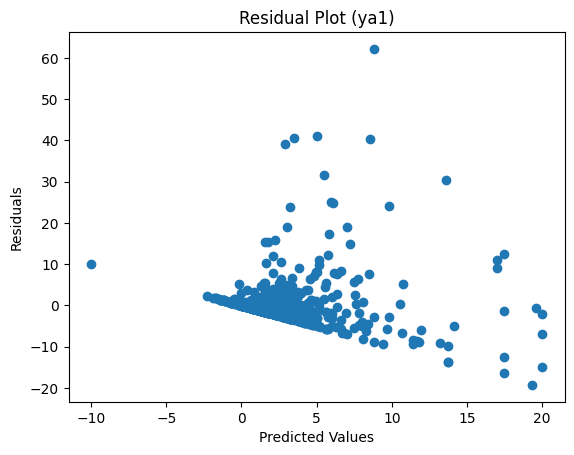

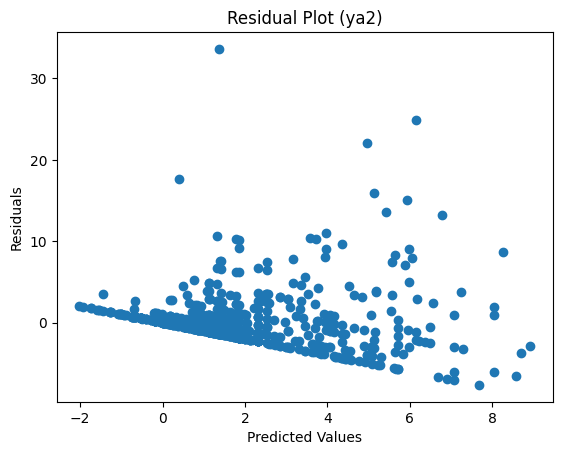

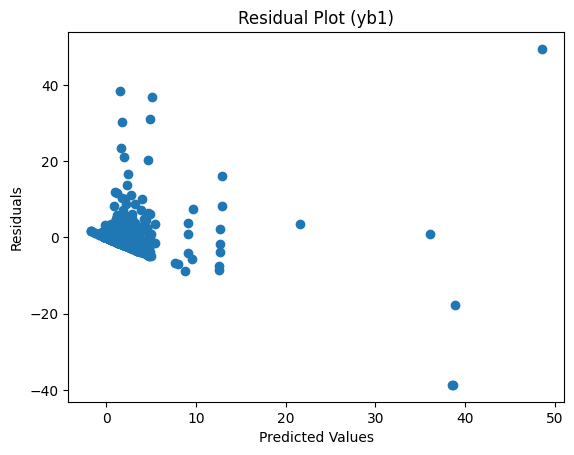

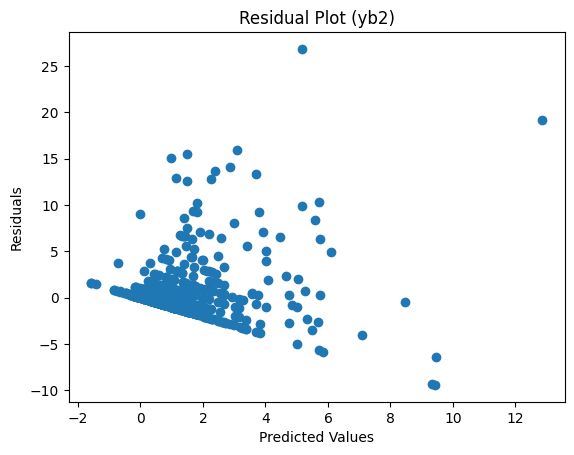

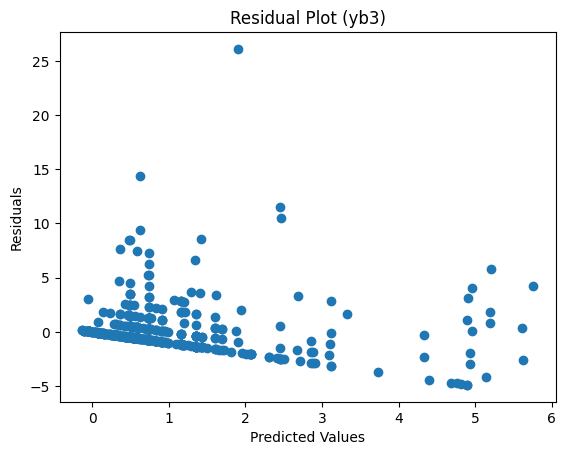

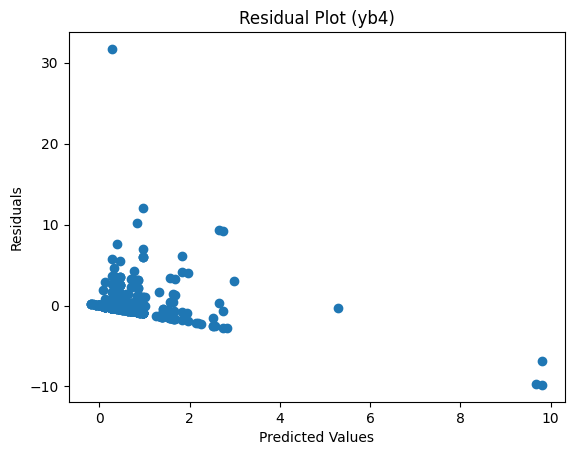

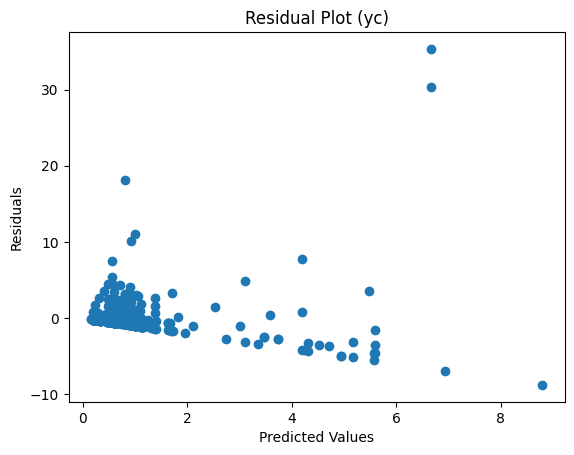

In [49]:
for var, estimator, X_test, y_test in zip(variables,
                                          estimators,
                                          X_tests,
                                          y_tests):
    residuals = y_test - predict[var]
    plt.scatter(predict[var], residuals)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f'Residual Plot ({var})')
    plt.show()

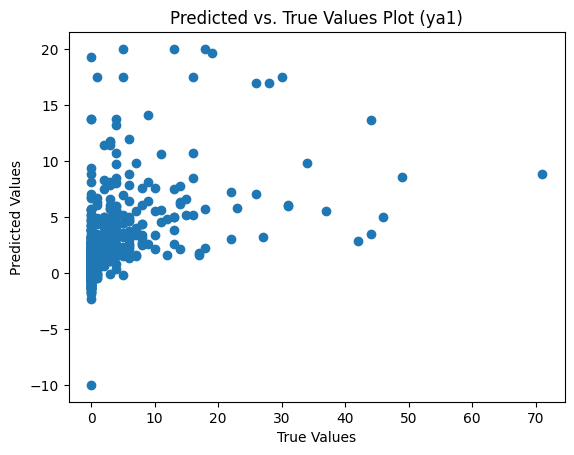

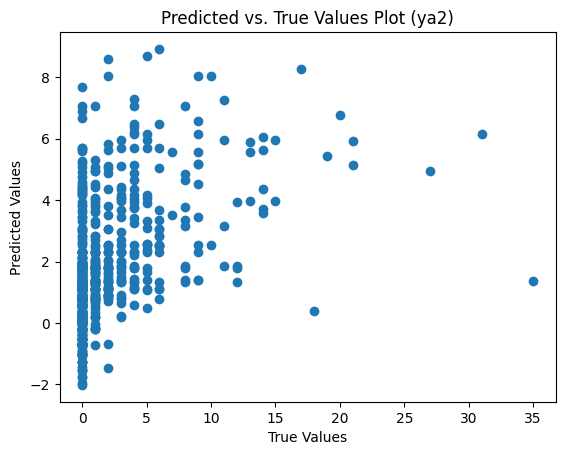

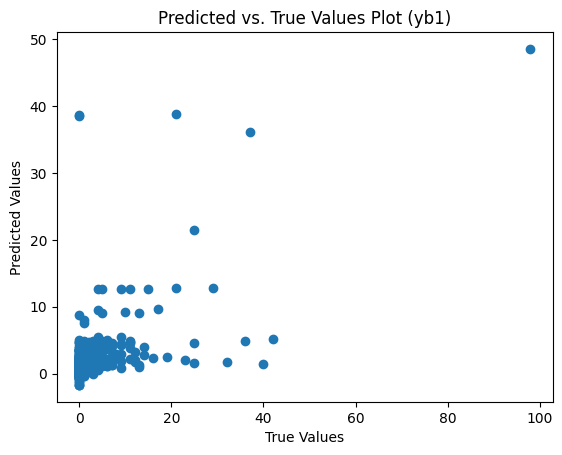

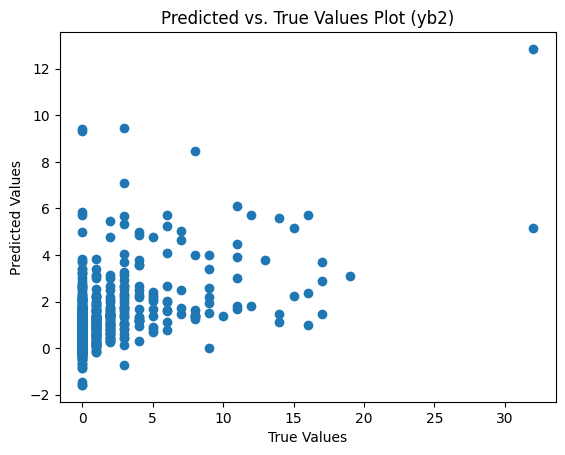

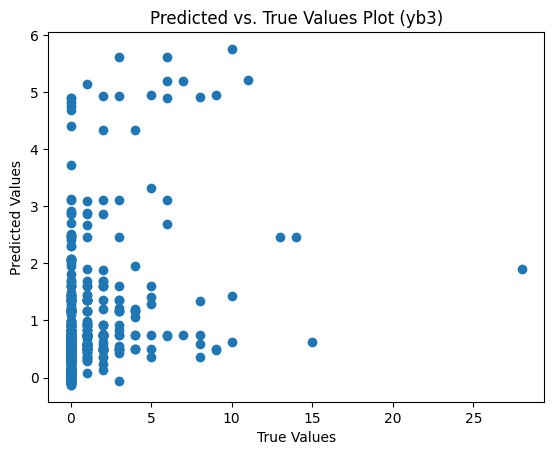

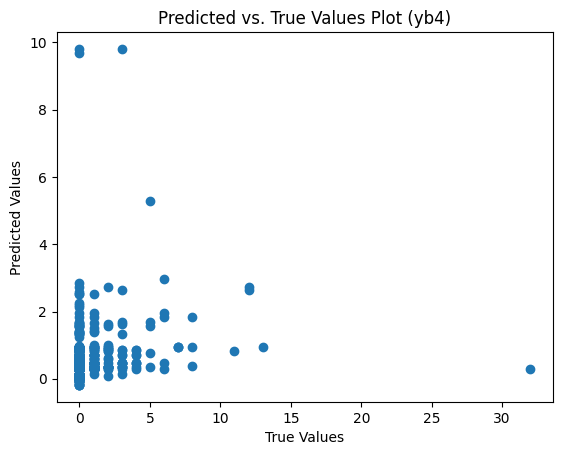

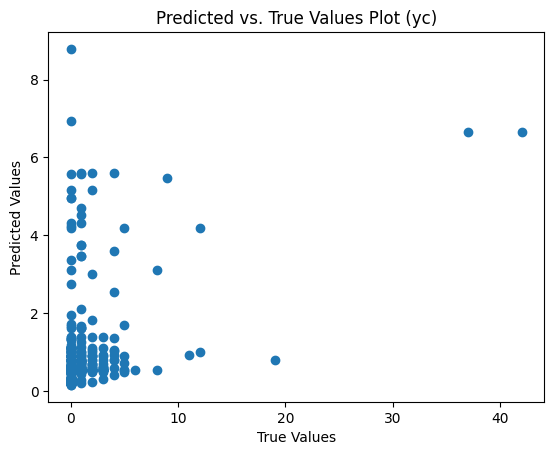

In [50]:
for var, estimator, X_test, y_test in zip(variables, estimators, X_tests, y_tests):
    plt.scatter(y_test, predict[var])
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f'Predicted vs. True Values Plot ({var})')
    plt.show()

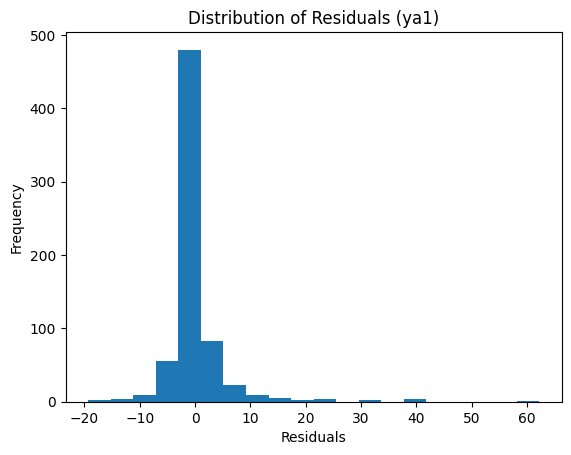

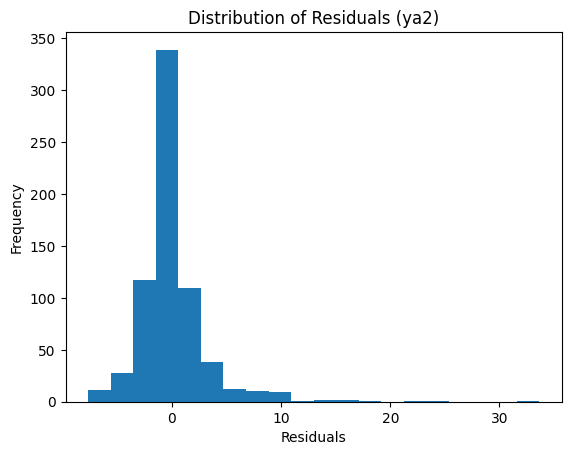

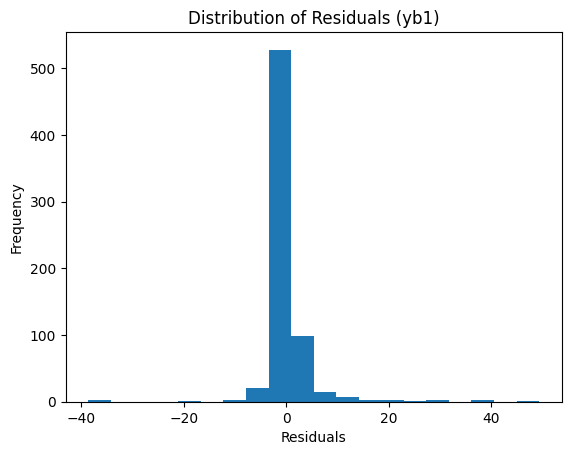

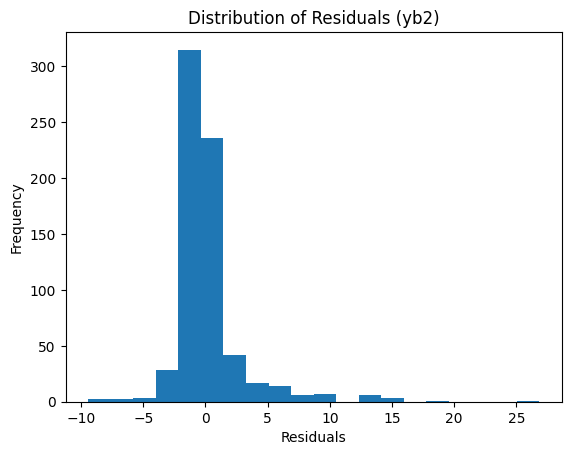

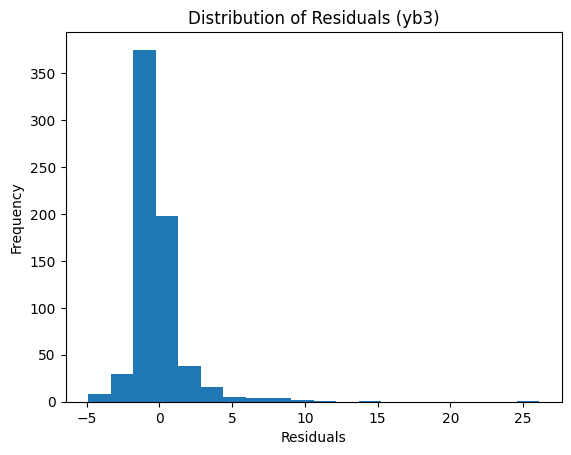

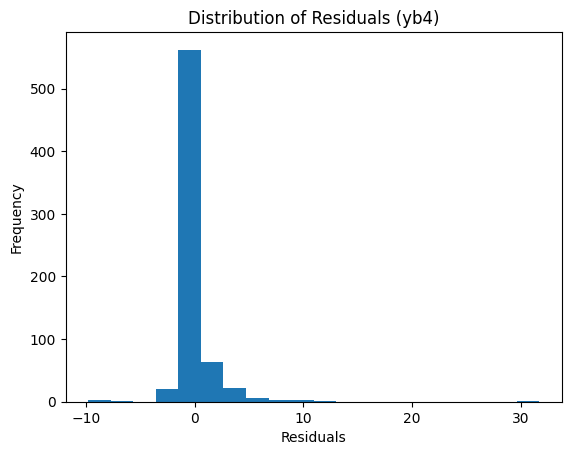

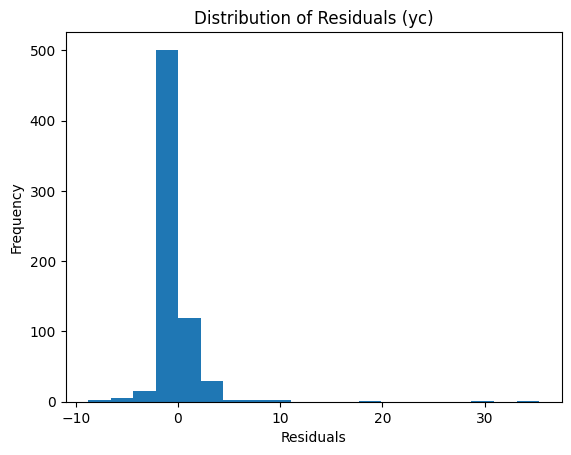

In [51]:
for var, estimator, X_test, y_test in zip(variables,
                                          estimators,
                                          X_tests,
                                          y_tests):
    plt.hist(y_test - predict[var], bins=20)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(f'Distribution of Residuals ({var})')
    plt.show()